In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.layers import Add, Concatenate, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.util import nest

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.callbacks import TQDMProgressBar

%run ../gridsearch/xception.ipynb

In [3]:
# A separate dataset for training a denoising network with fixed PSF and fixed noise
# Starting random seed for data generation 2314662
basedir = Path("../../")
dataset = basedir / "./data/data_v1a.npz"
modelpath = "./models/rdn.tf"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    noisy = data["img"]
    noiseless = data["img_nonoise"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


In [4]:
subset = 100_000
X = noisy[:subset, ..., np.newaxis]
Y = noiseless[:subset, ..., np.newaxis]

input_shape = X.shape[1:]

In [5]:
def RDB_conv(x, G=32):
    out = Conv2D(filters=G, kernel_size=3, padding="same", strides=1, activation="relu")(x)
    out = Concatenate()([x, out])
    return out


def RDB(x, C=6, G=32):
    inputs = x
    for _ in range(C):
        x = RDB_conv(x, G=G)
        
    # Local Feature Fusion
    x = Conv2D(filters=64, kernel_size=1, padding="same", strides=1)(x)  # alt: padding="valid"
    
    out = Add()([x, inputs])
    return out
        

def RDN(input_shape, D=20, C=6, G=32):
    """Build a Residual Dense Network.
    
    Args:
        input_shape: a 3-dimensional tuple of the input shape (including the channel dimension)
        D: the number of residual dense blocks
        C: the number of convolutional layers in each residual dense block
        D: growth rate of residual dense blocks
    """    
    inputs = Input(shape=input_shape)
    x = preprocessing.Normalization()(inputs)
    
    # Shallow feature extraction
    sfe1 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
    sfe2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(sfe1)
    x = sfe2
    
    RDBs = []
    for _ in range(D):
        x = RDB(x, C=C, G=G)
        RDBs.append(x)
        
    x = Concatenate()(RDBs)
    
    # Global Feature Fusion
    gff1 = Conv2D(filters=64, kernel_size=1, strides=1, padding="same")(x)  # alt: padding="valid"
    gff2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(gff1)
    
    x = Add()([gff2, sfe1])
    outputs = Conv2D(filters=input_shape[-1], kernel_size=3, strides=1, padding="same")(x)

    model = Model(inputs, outputs, name="RDN")
    return model

In [6]:
model = RDN(input_shape)
adapt_model(model, X)
model.summary()

Model: "RDN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   640         normalization[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
________________________________________________________________________________________________

                                                                 conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 32)   46112       concatenate_26[0][0]             
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 64, 64, 192)  0           concatenate_26[0][0]             
                                                                 conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 64, 64, 32)   55328       concatenate_27[0][0]             
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 64, 64, 224)  0           concatenate_27[0][0]             
          

concatenate_54 (Concatenate)    (None, 64, 64, 96)   0           add_8[0][0]                      
                                                                 conv2d_65[0][0]                  
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 64, 64, 32)   27680       concatenate_54[0][0]             
__________________________________________________________________________________________________
concatenate_55 (Concatenate)    (None, 64, 64, 128)  0           concatenate_54[0][0]             
                                                                 conv2d_66[0][0]                  
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 64, 64, 32)   36896       concatenate_55[0][0]             
__________________________________________________________________________________________________
concatenat

__________________________________________________________________________________________________
concatenate_83 (Concatenate)    (None, 64, 64, 256)  0           concatenate_82[0][0]             
                                                                 conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 64, 64, 64)   16448       concatenate_83[0][0]             
__________________________________________________________________________________________________
add_13 (Add)                    (None, 64, 64, 64)   0           conv2d_99[0][0]                  
                                                                 add_12[0][0]                     
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 64, 64, 32)   18464       add_13[0][0]                     
__________

conv2d_131 (Conv2D)             (None, 64, 64, 32)   46112       concatenate_110[0][0]            
__________________________________________________________________________________________________
concatenate_111 (Concatenate)   (None, 64, 64, 192)  0           concatenate_110[0][0]            
                                                                 conv2d_131[0][0]                 
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 64, 64, 32)   55328       concatenate_111[0][0]            
__________________________________________________________________________________________________
concatenate_112 (Concatenate)   (None, 64, 64, 224)  0           concatenate_111[0][0]            
                                                                 conv2d_132[0][0]                 
__________________________________________________________________________________________________
conv2d_133

In [7]:
batch_size = 32

# 90% train, 10% test
n_train = int(X.shape[0] * 0.9)
n_val = X.shape[0] - n_train

train_steps = int(np.ceil(n_train / batch_size))
val_steps = int(np.ceil(n_val / batch_size))

X_train, Y_train = X[:n_train], Y[:n_train]
X_val, Y_val = X[n_train:], Y[n_train:]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(X.shape[0]).batch(batch_size).repeat()
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

In [8]:
# Setup callbacks. TQDM is used due to issues with the default progress bar on my TF2.1 installation.
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
tqdm_callback = TQDMProgressBar()
checkpoint = ModelCheckpoint(modelpath, save_best_only=True)

model.compile(optimizer=Adam(0.0001), loss="mae")
history = model.fit(
    train_ds,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    epochs=1000,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)
model.save(modelpath)

Epoch 1/1000



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 2/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 3/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 4/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 5/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 6/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 7/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 8/1000



Epoch 9/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 10/1000



Epoch 11/1000



Epoch 12/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 13/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 14/1000



Epoch 15/1000



INFO:tensorflow:Assets written to: ./models/rdn.tf/assets
Epoch 16/1000



Epoch 17/1000



Epoch 18/1000



Epoch 19/1000



Epoch 20/1000



Epoch 21/1000



Epoch 22/1000



Epoch 23/1000



Epoch 24/1000



Epoch 25/1000



Epoch 26/1000



Epoch 27/1000



Epoch 28/1000



Epoch 29/1000



Epoch 30/1000



Epoch 31/1000



Epoch 32/1000



Epoch 33/1000



Epoch 34/1000



Epoch 35/1000




INFO:tensorflow:Assets written to: ./models/rdn.tf/assets


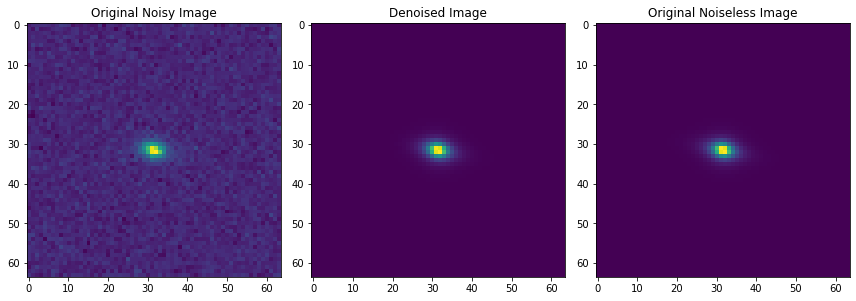

In [9]:
# Plot the results
# model = tf.keras.models.load_model("./models/rdn.tf")
image_idx = 1
pred = model.predict(val_ds.take(1))[image_idx]

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
ax[0].imshow(X_val[image_idx].reshape(64, 64))
ax[0].set_title("Original Noisy Image")
ax[1].imshow(pred.reshape(64, 64))
ax[1].set_title("Denoised Image")
ax[2].imshow(Y_val[image_idx].reshape(64, 64))
ax[2].set_title("Original Noiseless Image");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


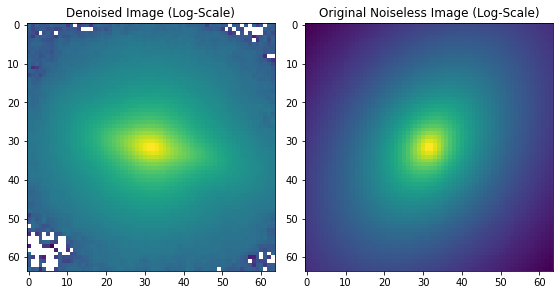

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax[0].imshow(np.log(pred).reshape(64, 64))
ax[0].set_title("Denoised Image (Log-Scale)")
ax[1].imshow(np.log(Y[image_idx]).reshape(64, 64))
ax[1].set_title("Original Noiseless Image (Log-Scale)");